### Importing required libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tabulate import tabulate

### Declaring the Variables

In [ ]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE=16
FOLDS=10
SCORES_PER_FOLD=[]
CLASSES=["1-1","1-2","1-4","PURE"]

In [ ]:
image_dir='/content/drive/MyDrive/Project_2/BLACK_WHITE'

In [ ]:
logdir='/content/drive/MyDrive/Project_2/CNN_Model_Related/Logs'

In [ ]:
model_dir='/content/drive/MyDrive/Project_2/CNN_Model_Related/Model/'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Fetching and Preprocessing the image files

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
image_data_set =tf.keras.utils.image_dataset_from_directory(
  image_dir,
  label_mode='int',
  seed=131,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
)

Found 2240 files belonging to 4 classes.


In [ ]:
train_val_set=image_data_set.take(100)
test_set=image_data_set.skip(100).take(40)
print(f'Using {len(train_val_set)} sets for Training and Validation')
print(f'Using {len(test_set)} sets for Testing')

Using 100 sets for Training and Validation
Using 40 sets for Testing


In [ ]:
normalized_train_val_set=train_val_set.map(lambda x,y: (normalization_layer(x), y))
normalized_testing_set=test_set.map(lambda x,y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_training_set))      #<-----the data is fethched in this form: image batch, label batch

### Building the CNN Model

In [ ]:
def Build_Model():
  model=Sequential()
  
  model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dense(4, activation='sigmoid'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
# Summary of the model
model=Build_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Peforming the 10 Fold Cross Validation

In [ ]:
i=0
j=10
k=90

for fold_var in range(0,FOLDS,1):
  print(f'Fold {fold_var+1}')
  print('--------------------------------------------------------------------------------------------')
  training_set1=normalized_train_val_set.take(i)
  training_set2=normalized_train_val_set.skip(i+j).take(k)
  training_set=training_set1.concatenate(training_set2)
  validation_set=normalized_train_val_set.skip(i).take(j)
  i=i+10
  j=10
  k=k-10
  
  model=Build_Model()
  Model_Run = model.fit(
    training_set,
    epochs=15,
    steps_per_epoch=len(training_set),
    callbacks=[tensorboard_callback]
  )
  print('\n')
  print(f'Evaluating the model')
  print('\n')
  cur_scores=model.evaluate(validation_set)
  cur_scores[0]*=100
  cur_scores[1]*=100
  cur_scores=[fold_var+1,cur_scores[0],cur_scores[1]]
  SCORES_PER_FOLD.append(cur_scores)

  model.save(model_dir+'model_'+str(fold_var+1)+'.h5')
  print('--------------------------------------------------------------------------------------------')
  tf.keras.backend.clear_session()


Fold 1
--------------------------------------------------------------------------------------------
Epoch 1/15
90/90 [==============================] - 446s 4s/step - loss: 0.6571 - accuracy: 0.7111
Epoch 2/15
90/90 [==============================] - 7s 73ms/step - loss: 0.4670 - accuracy: 0.8014
Epoch 3/15
90/90 [==============================] - 6s 57ms/step - loss: 0.3652 - accuracy: 0.8389
Epoch 4/15
90/90 [==============================] - 7s 60ms/step - loss: 0.3918 - accuracy: 0.8229
Epoch 5/15
90/90 [==============================] - 6s 61ms/step - loss: 0.3372 - accuracy: 0.8507
Epoch 6/15
90/90 [==============================] - 6s 57ms/step - loss: 0.3476 - accuracy: 0.8569
Epoch 7/15
90/90 [==============================] - 7s 74ms/step - loss: 0.3047 - accuracy: 0.8674
Epoch 8/15
90/90 [==============================] - 6s 56ms/step - loss: 0.3625 - accuracy: 0.8632
Epoch 9/15
90/90 [==============================] - 7s 69ms/step - loss: 0.3326 - accuracy: 0.8667
Epoch 10/

In [ ]:
column_headers=['Fold Number','Validation Loss(%)','Validation Accuracy(%)']
print(tabulate(SCORES_PER_FOLD, headers=column_headers, tablefmt="grid"))

+---------------+----------------------+--------------------------+
|   Fold Number |   Validation Loss(%) |   Validation Accuracy(%) |
+===============+======================+==========================+
|             1 |             11.9479  |                   97.5   |
+---------------+----------------------+--------------------------+
|             2 |              4.69334 |                   98.75  |
+---------------+----------------------+--------------------------+
|             3 |             14.7684  |                   96.25  |
+---------------+----------------------+--------------------------+
|             4 |              8.22934 |                   97.5   |
+---------------+----------------------+--------------------------+
|             5 |              8.59968 |                   98.125 |
+---------------+----------------------+--------------------------+
|             6 |              8.30335 |                   94.375 |
+---------------+----------------------+--------

### Selecting the model with highest accuracy for training

In [ ]:
max_acc=SCORES_PER_FOLD[0][2]
max_acc_index=[]
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]>max_acc):
    max_acc=SCORES_PER_FOLD[i][2]
print(max_acc)
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]==max_acc):
    max_acc_index.append(i)
print(max_acc_index)
result=-1
if(len(max_acc_index)>1):
  min_loss=SCORES_PER_FOLD[max_acc_index[0]][1]
  j=0
  result=-1
  while(index<len(SCORES_PER_FOLD)):
    index=max_acc_index[j]
    if(SCORES_PER_FOLD[index][1]<min_loss):
      min_loss=SCORES_PER_FOLD[index][1]
      result=index
    j+=1
else:
  result=max_acc_index[0]

model=load_model(model_dir+'model_'+str(result+1)+'.h5')

98.7500011920929
[1]


### Training the model for fine parameter tuning

In [ ]:
training_set=normalized_train_val_set.take(80)
validation_set=normalized_train_val_set.skip(80).take(20)

Cur_Model_Run = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=25,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[tensorboard_callback]
  )

Epoch 1/25
80/80 [==============================] - 13s 135ms/step - loss: 0.1440 - accuracy: 0.9469 - val_loss: 0.0510 - val_accuracy: 0.9844
Epoch 2/25
80/80 [==============================] - 11s 129ms/step - loss: 0.1123 - accuracy: 0.9594 - val_loss: 0.0505 - val_accuracy: 0.9875
Epoch 3/25
80/80 [==============================] - 11s 128ms/step - loss: 0.0790 - accuracy: 0.9758 - val_loss: 0.0434 - val_accuracy: 0.9906
Epoch 4/25
80/80 [==============================] - 10s 113ms/step - loss: 0.0872 - accuracy: 0.9789 - val_loss: 0.1316 - val_accuracy: 0.9656
Epoch 5/25
80/80 [==============================] - 11s 129ms/step - loss: 0.0969 - accuracy: 0.9695 - val_loss: 0.0266 - val_accuracy: 0.9906
Epoch 6/25
80/80 [==============================] - 11s 130ms/step - loss: 0.0644 - accuracy: 0.9805 - val_loss: 0.1484 - val_accuracy: 0.9531
Epoch 7/25
80/80 [==============================] - 10s 117ms/step - loss: 0.0929 - accuracy: 0.9703 - val_loss: 0.0716 - val_accuracy: 0.9781

### Plotting the performance of the model after fine parameter tuning

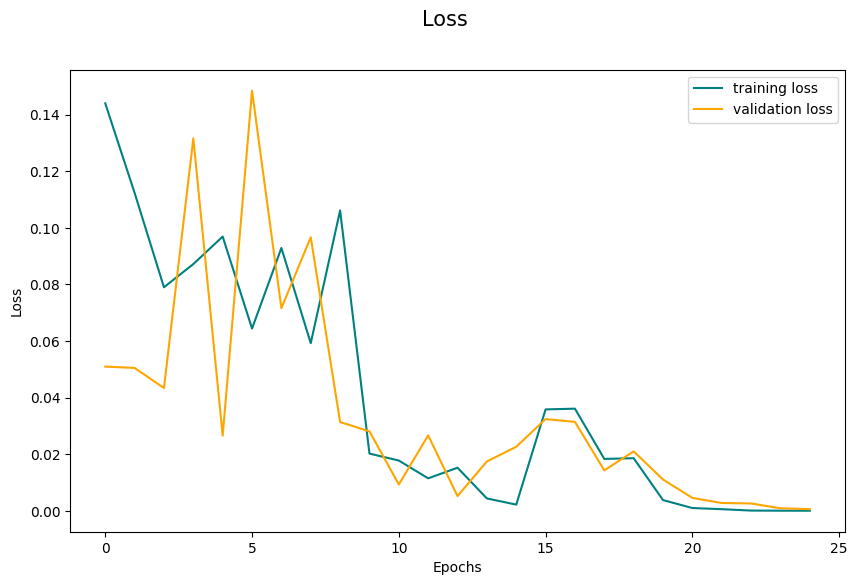

In [ ]:
# Plotting the loss


fig=plt.figure(figsize=(10,6));
plt.plot(Cur_Model_Run.history['loss'], color='teal', label='training loss')
plt.plot(Cur_Model_Run.history['val_loss'], color='orange', label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()

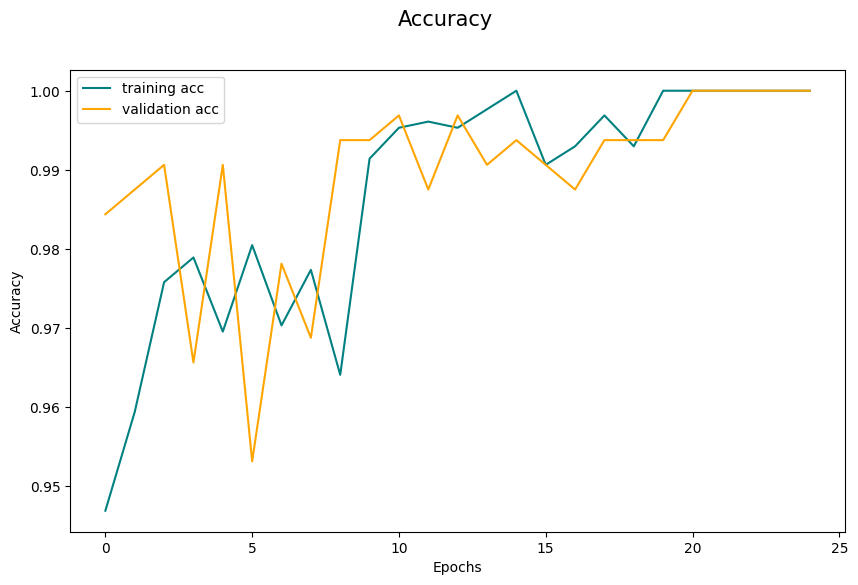

In [ ]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6));
plt.plot(Cur_Model_Run.history['accuracy'], color='teal', label='training acc')
plt.plot(Cur_Model_Run.history['val_accuracy'], color='orange', label='validation acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()

###Calcualting Precision, Recall, Accuracy and F Score of the Model

In [ ]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [ ]:
True_label=[]
Predicted_label=[]
score=[]
for images,labels in (normalized_testing_set):              
  score.append(model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 24ms/step


In [ ]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}')

Precision: 0.9958763122558594, Recall: 0.9979338645935059, Accuracy: 0.9906250238418579, F Score: 0.9969040267585142


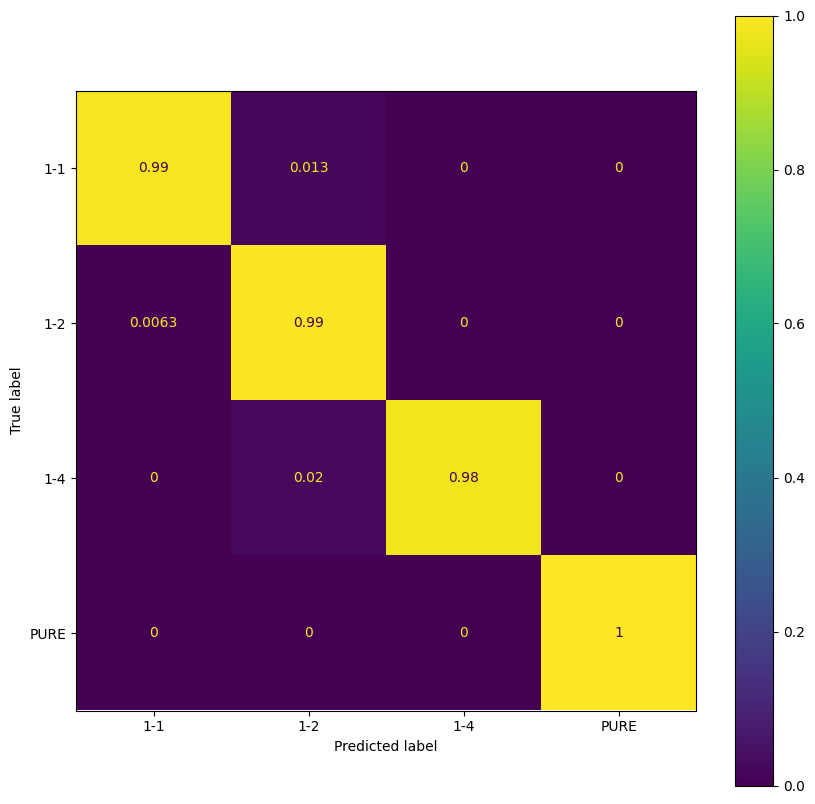

In [ ]:
confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show();

### Demonstrating how to use the model

In [ ]:
img=image.load_img('/content/drive/MyDrive/Project_2/BLACK_WHITE/1-4/CR_B_DU_1-4_013.jpg',target_size=(256,256))

In [ ]:
x=image.img_to_array(img)

In [ ]:
x=x/255

In [ ]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 256, 256, 3)

In [ ]:
pred=model.predict(x)

1/1 [==============================] - 0s 171ms/step


In [ ]:
print(pred)

[[8.2065639e-12 6.4013165e-01 1.0000000e+00 1.9904557e-27]]


In [ ]:
pred_name = CLASSES[np.argmax(pred)]
print(pred_name)

1-4
